# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

# Dataset

In [4]:
# Loading dataset
df = pd.read_pickle(r'C:\Users\NLP\Project\dataset\justice.csv') #publicly accessible data path
df.rename(columns={'Facts': 'facts'}, inplace=True)
df.drop(columns=['index'], inplace=True)
df.reset_index(inplace=True)

print(f'There are {len(df)} cases.')

There are 3464 cases.


In [5]:
df.head(5)

,index,ID,name,href,first_party,second_party,winning_party,winner_index,facts
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,Jane Roe,Henry Wade,Jane Roe,0,"In 1970, Jane Roe (a fictional name used in co..."
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,"Peter Stanley, Sr.",Illinois,Stanley,0,Joan Stanley had three children with Peter Sta...
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,John Giglio,United States,Giglio,0,John Giglio was convicted of passing forged mo...
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,Sally Reed,Cecil Reed,Sally Reed,0,"The Idaho Probate Code specified that ""males m..."
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,Marvin Miller,California,Marvin Miller,0,"Miller, after conducting a mass mailing campai..."


# Data Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3464 entries, 0 to 3463
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          3464 non-null   int64 
 1   ID             3464 non-null   int64 
 2   name           3464 non-null   object
 3   href           3464 non-null   object
 4   first_party    3464 non-null   object
 5   second_party   3464 non-null   object
 6   winning_party  3464 non-null   object
 7   winner_index   3464 non-null   int64 
 8   facts          3464 non-null   object
dtypes: int64(3), object(6)
memory usage: 243.7+ KB


In [7]:
df.isna().sum()

index            0
ID               0
name             0
href             0
first_party      0
second_party     0
winning_party    0
winner_index     0
facts            0
dtype: int64

In [8]:
print(f'There are {len(df)} cases.')
print(f'There are {len(df[df["winner_index"]==0])} rows for class 0.')
print(f'There are {len(df[df["winner_index"]==1])} rows for class 1.')

There are 3464 cases.
There are 2114 rows for class 0.
There are 1350 rows for class 1.


In [9]:
df['facts'].apply(lambda x: len(str(x).split())).describe()

count    3464.000000
mean      188.618938
std        91.496982
min        13.000000
25%       125.000000
50%       176.000000
75%       239.000000
max       974.000000
Name: facts, dtype: float64

In [10]:
# Seqence Model Check
text_vectorization = keras.layers.TextVectorization(
    max_tokens=1000, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting integer encodings (which means we'll have a sequence of integers)
)
text_vectorization.adapt(df['facts'])
vectorized_facts = text_vectorization(df['facts'])


lengths = [len(x) for x in vectorized_facts]

In [11]:
name_pet = []
name_rep = []
for i in range(df.shape[0]):
    fact = df["facts"][i]
    petitioner = df["first_party"][i]
    respondent = df["second_party"][i]
    p = True
    r = True
    for _ in petitioner.split():
        if _ in fact:
            p = True
            break
        else:
            p = False
    if p == False:
        name_pet.append(i)
    for _ in respondent.split():
        if _ in fact:
            r = True
            break
        else:
            r = False
    if r == False:
        name_rep.append(i)

In [12]:
perc_miss_pet = len(name_pet) / len(df) * 100
print('{:.2f}% of facts don\'t contain the first party name'.format(perc_miss_pet))

perc_miss_rep = len(name_rep) / len(df) * 100
print('{:.2f}% of facts don\'t contain the second party name'.format(perc_miss_rep))

perc_miss_both = len(set(set(name_pet) & set(name_rep))) / len(df) * 100
print('{:.2f}% of facts don\'t contain both first party the second party names'.format(perc_miss_both))

13.05% of facts don't contain the first party name
17.18% of facts don't contain the second party name
1.93% of facts don't contain both first party the second party names


In [13]:
# Combining first and second party with facts
df['facts'] = df['first_party']+' '+df['second_party']+' '+df['facts']
df['facts'][50]

'United States Robinson A police officer pulled over and arrested Robinson for operating an automobile without a valid permit. The officer then frisked Robinson and discovered a crumpled cigarette package containing fourteen vials of heroin in his pocket.'

winner_index
0    2114
1    1350
Name: count, dtype: int64


<Axes: ylabel='Type'>

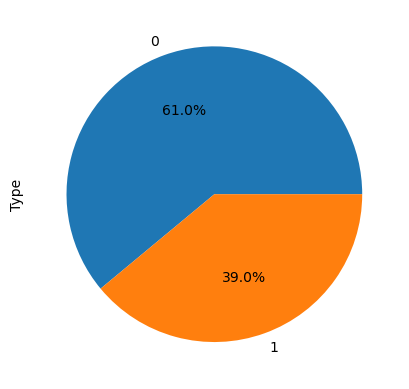

In [14]:
print(df["winner_index"].value_counts())

df.groupby('winner_index').size().plot(kind='pie',
                                       y = "winner_index",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [15]:
# Spliting 70-30 for training and testing data
X_train, X_test, \
y_train, y_test = train_test_split(
    df[['winner_index', 'facts']],
    df['winner_index'],
    test_size=0.2,
    stratify=df['winner_index'],
    random_state=865
)

In [16]:
petitioner = X_train[X_train["winner_index"] == 0]
respondent = X_train[X_train["winner_index"] == 1]
print(petitioner.shape)
print(respondent.shape)

(1691, 2)
(1080, 2)


In [17]:
#Upsample data
from sklearn.utils import resample
upsample_respondent = resample(respondent,
             replace=True,
             n_samples=len(petitioner),
             random_state=865)

winner_index
1    1691
0    1691
Name: count, dtype: int64


<Axes: ylabel='Type'>

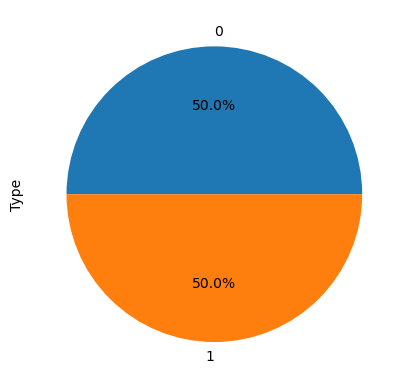

In [18]:
upsample_train = pd.concat([upsample_respondent, petitioner])

print(upsample_train["winner_index"].value_counts())

upsample_train.groupby('winner_index').size().plot(kind='pie',
                                       y = "winner_index",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [19]:
#shuffling
shuffled_indices= np.arange(upsample_train.shape[0])
np.random.shuffle(shuffled_indices)

In [20]:
shuffled_train = upsample_train.iloc[shuffled_indices,:]
X_train= shuffled_train['facts']
y_train = shuffled_train['winner_index']

In [21]:
X_test = X_test['facts']

# Algorithms Implementation

# 1- Neural Network:

In [23]:
def nltk_tokenizer(_wd):
    return RegexpTokenizer(r'\w+').tokenize(_wd.lower())

In [24]:
# turn X data into pandas dataframe to use custom defined function on a column in dataframe
X_train_frame = X_train.to_frame()
X_test_frame = X_test.to_frame()

# tokenize facts
X_train_frame["tokenized_facts"] = X_train_frame["facts"].apply(nltk_tokenizer)
X_test_frame["tokenized_facts"] = X_test_frame["facts"].apply(nltk_tokenizer)

# make taggeddocument, which is required format to use Doc2vec
tokens_train = X_train_frame["tokenized_facts"].to_list()
docs_train = [TaggedDocument(t, [str(i)]) for i, t in enumerate(tokens_train)]
tokens_test = X_test_frame["tokenized_facts"].to_list()
docs_test = [TaggedDocument(t, [str(i)]) for i, t in enumerate(tokens_test)]

In [25]:
# innitiate doc2vec model and train it on train data
doc2vec_model = Doc2Vec(vector_size=50, min_count=2, epochs=40, dm=1, seed=865, window=5)
doc2vec_model.build_vocab(docs_train)
doc2vec_model.train(docs_train, total_examples = doc2vec_model.corpus_count, epochs = doc2vec_model.epochs)

In [26]:
# vectorize train and test data using doc2vec model
X_train_dvs = [doc2vec_model.infer_vector(doc) for doc in tokens_train]
X_train_dvs = pd.DataFrame(X_train_dvs, index = X_train.index)

X_test_dvs = [doc2vec_model.infer_vector(doc) for doc in tokens_test]
X_test_dvs = pd.DataFrame(X_test_dvs, index = X_test.index)

In [27]:
# define Dense layer model
def simple_model():
    model =  keras.Sequential([
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(200, activation="relu", kernel_regularizer="l1"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(100, activation="relu", kernel_regularizer="l1"),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        layers.Dense(50, activation="relu"),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        layers.Dense(20, activation="relu"),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
# training and cross validattion
k = 4
num_validation_samples = len(X_train_dvs) // k
num_epochs = 20
batch_sizes = 50
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history.
for fold in range(k):
    validation_data = X_train_dvs[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        X_train_dvs[:num_validation_samples * fold],
        X_train_dvs[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])

    model1 = simple_model()

    history1 = model1.fit(training_data, training_targets,
                    validation_data = (validation_data,validation_targets),
                    epochs=num_epochs, batch_size=batch_sizes)

    val_loss_history1 = history1.history['val_loss']
    val_acc_history1 = history1.history['val_accuracy']
    loss_history1 = history1.history['loss']
    acc_history1 = history1.history['accuracy']
    all_val_loss_histories.append(val_loss_history1)
    all_loss_histories.append(loss_history1)
    all_val_acc_histories.append(val_acc_history1)
    all_acc_histories.append(acc_history1)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/20
51/51 [==============================] - 5s 16ms/step - loss: 18.9476 - accuracy: 0.5522 - val_loss: 15.2839 - val_accuracy: 0.5834
Epoch 2/20
51/51 [==============================] - 0s 7ms/step - loss: 12.6568 - accuracy: 0.5980 - val_loss: 10.0802 - val_accuracy: 0.5148
Epoch 3/20
51/51 [==============================] - 0s 7ms/step - loss: 8.0857 - accuracy: 0.6815 - val_loss: 6.4210 - val_accuracy: 0.5065
Epoch 4/20
51/51 [==============================] - 0s 7ms/step - loss: 4.9123 - accuracy: 0.7568 - val_loss: 4.0802 - val_accuracy: 0.5065
Epoch 5/20
51/51 [==============================] - 0s 7ms/step - loss: 3.0586 - accuracy: 0.7875 - val_loss: 2.9140 - val_accuracy: 0.5065
Epoch 6/20
51/51 [==============================] - 0s 7ms/step - loss: 2.2195 - accuracy: 0.8057 - val_loss: 2.3146 - val_accuracy: 0.5065
Epoch 7/20
51/51 [==============================] - 0s 7ms/step - loss: 1.8740 - accuracy: 0.8140 - val_loss: 2.1490 - val_accuracy: 0.5065
Epoch 8/20
51/5

In [ ]:
np.mean(average_val_acc_history)

0.6943343222141266

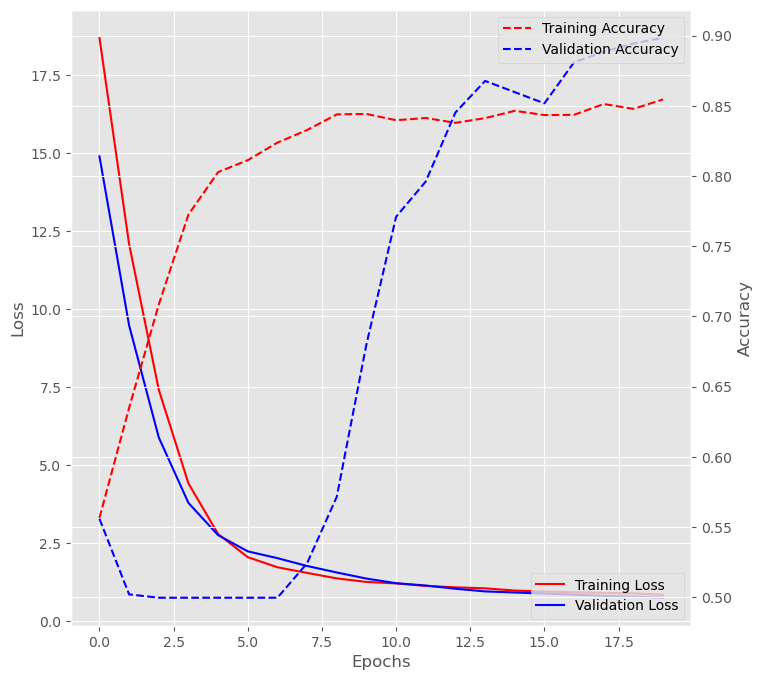

In [ ]:
# plot loss and accuracy on train, validation data

plt.style.use('ggplot')

fig, ax=plt.subplots(figsize=(8,8))
ax.plot(average_loss_history,c='r', label="Training Loss")
ax.plot(average_val_loss_history,c='b', label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend(['Training Loss','Validation Loss'], loc="lower right")

ax2=ax.twinx()
ax2.plot(average_acc_history,c="r",linestyle="dashed", label="Training Accuracy")
ax2.plot(average_val_acc_history,c='b',linestyle="dashed", label="Validation Accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend(["Training Accuracy", "Validation Accuracy"], loc="upper right")

plt.show()

22/22 [==============================] - 0s 3ms/step


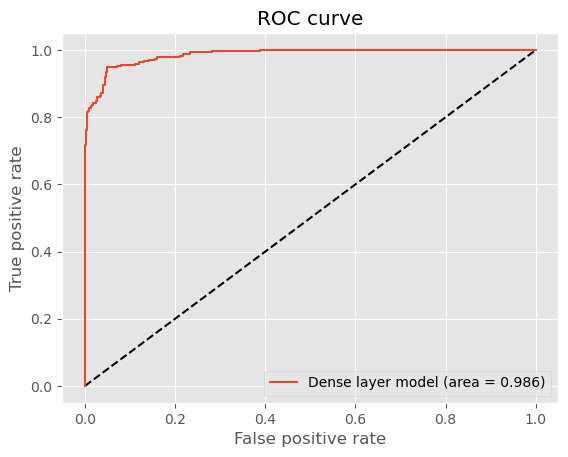

In [ ]:
from sklearn.metrics import roc_curve
y_pred1 = model1.predict(X_test_dvs).ravel()
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred1)

from sklearn.metrics import auc
auc_1 = auc(fpr_1, tpr_1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Dense layer model (area = {:.3f})'.format(auc_1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# model evaluation using test data
loss_metrics = model1.evaluate(X_test_dvs,y_test,verbose=1)

22/22 [==============================] - 0s 5ms/step - loss: 0.6309 - accuracy: 0.9235


# 2-  Convolutional Neural Network

In [ ]:
# Before building CNN model, vectorize facts data
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000,
    output_mode="int",
    output_sequence_length = 500
)

text_vectorization.adapt(X_train)

X_train_processed = text_vectorization(X_train)
X_test_processed = text_vectorization(X_test)

In [ ]:
# Build CNN model
def cnn_model():
    input = keras.Input(shape=(500))
    x = layers.Embedding(input_dim=2000,output_dim=8,input_length=500, mask_zero=True)(input)
    x = layers.Conv1D(filters=40,kernel_size=10,activation="relu")(x)
    x = layers.MaxPool1D(pool_size=2,strides=2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(10,activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=input,outputs=output)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
    return model

In [ ]:
# train and cross validate the model
k = 4
num_validation_samples = len(X_train_dvs) // k
num_epochs = 20
batch_sizes = 50
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history.
for fold in range(k):
    validation_data = X_train_processed[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        X_train_processed[:num_validation_samples * fold],
        X_train_processed[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])

    model2 = cnn_model()

    history2 = model2.fit(training_data, training_targets,
                    validation_data = (validation_data,validation_targets),
                    epochs=num_epochs, batch_size=batch_sizes)

    val_loss_history2 = history2.history['val_loss']
    val_acc_history2 = history2.history['val_accuracy']
    loss_history2 = history2.history['loss']
    acc_history2 = history2.history['accuracy']
    all_val_loss_histories.append(val_loss_history2)
    all_loss_histories.append(loss_history2)
    all_val_acc_histories.append(val_acc_history2)
    all_acc_histories.append(acc_history2)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/20
51/51 [==============================] - 4s 45ms/step - loss: 0.6924 - accuracy: 0.5388 - val_loss: 0.6902 - val_accuracy: 0.5976
Epoch 2/20
51/51 [==============================] - 2s 40ms/step - loss: 0.6814 - accuracy: 0.6117 - val_loss: 0.6620 - val_accuracy: 0.7065
Epoch 3/20
51/51 [==============================] - 2s 40ms/step - loss: 0.6158 - accuracy: 0.6926 - val_loss: 0.5476 - val_accuracy: 0.7846
Epoch 4/20
51/51 [==============================] - 2s 47ms/step - loss: 0.5029 - accuracy: 0.7828 - val_loss: 0.4291 - val_accuracy: 0.8450
Epoch 5/20
51/51 [==============================] - 2s 40ms/step - loss: 0.3702 - accuracy: 0.8565 - val_loss: 0.3138 - val_accuracy: 0.8769
Epoch 6/20
51/51 [==============================] - 2s 41ms/step - loss: 0.2656 - accuracy: 0.9145 - val_loss: 0.2356 - val_accuracy: 0.9065
Epoch 7/20
51/51 [==============================] - 2s 41ms/step - loss: 0.1897 - accuracy: 0.9322 - val_loss: 0.2109 - val_accuracy: 0.9231
Epoch 8/20
51

Epoch 19/20
51/51 [==============================] - 2s 36ms/step - loss: 0.0232 - accuracy: 0.9961 - val_loss: 0.1598 - val_accuracy: 0.9550
Epoch 20/20
51/51 [==============================] - 2s 35ms/step - loss: 0.0189 - accuracy: 0.9972 - val_loss: 0.1602 - val_accuracy: 0.9550
Epoch 1/20
51/51 [==============================] - 3s 43ms/step - loss: 0.6888 - accuracy: 0.5424 - val_loss: 0.6800 - val_accuracy: 0.6627
Epoch 2/20
51/51 [==============================] - 2s 39ms/step - loss: 0.6504 - accuracy: 0.6657 - val_loss: 0.6044 - val_accuracy: 0.7337
Epoch 3/20
51/51 [==============================] - 2s 41ms/step - loss: 0.5451 - accuracy: 0.7568 - val_loss: 0.4874 - val_accuracy: 0.8024
Epoch 4/20
51/51 [==============================] - 2s 38ms/step - loss: 0.4297 - accuracy: 0.8471 - val_loss: 0.3769 - val_accuracy: 0.8639
Epoch 5/20
51/51 [==============================] - 2s 36ms/step - loss: 0.3168 - accuracy: 0.8908 - val_loss: 0.2871 - val_accuracy: 0.8994
Epoch 6/20


In [ ]:
np.mean(average_val_acc_history)

0.8922928988933563

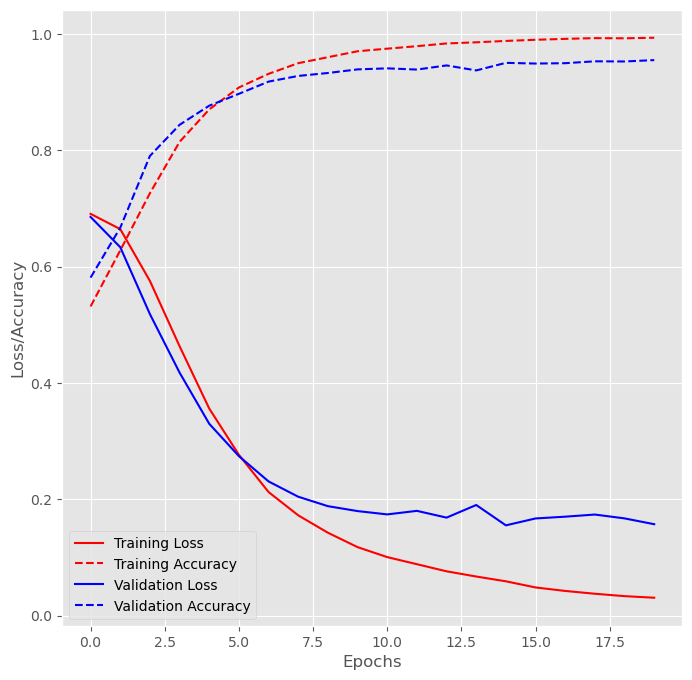

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

22/22 [==============================] - 0s 7ms/step


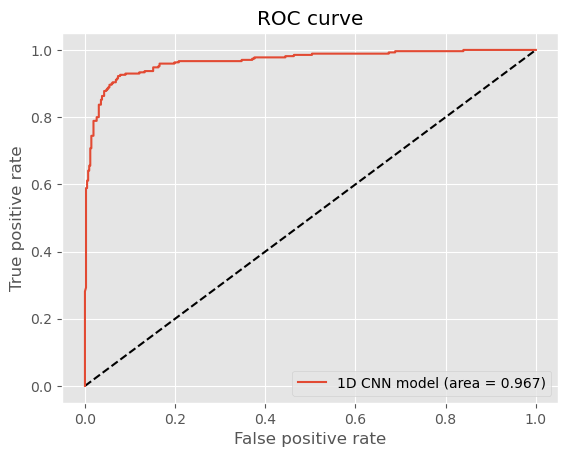

In [ ]:
from sklearn.metrics import roc_curve
y_pred2 = model2.predict(X_test_processed).ravel()
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred2)

from sklearn.metrics import auc
auc_2 = auc(fpr_2, tpr_2)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_2, tpr_2, label='1D CNN model (area = {:.3f})'.format(auc_2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
loss_metrics = model2.evaluate(X_test_processed,y_test,verbose=1)

22/22 [==============================] - 0s 10ms/step - loss: 0.2665 - accuracy: 0.9235


# 3- Bi-grams + TD-IDF

In [ ]:
text_vectorization_bi_tfidf = keras.layers.TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode = "tf_idf",
)

In [ ]:
text_vectorization_bi_tfidf.adapt(X_train)

In [ ]:
binary_2gram_tfidf_text = text_vectorization_bi_tfidf(X_train)
binary_2gram_tfidf_text

<tf.Tensor: shape=(3382, 20000), dtype=float32, numpy=
array([[671.9587   ,  23.602245 ,   6.294734 , ...,   0.       ,
          0.       ,   0.       ],
       [509.2187   ,  10.412756 ,   4.8959045, ...,   0.       ,
          0.       ,   0.       ],
       [362.22772  ,  13.883675 ,   5.5953193, ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [467.22128  ,   6.9418373,   5.5953193, ...,   0.       ,
          0.       ,   0.       ],
       [262.48386  ,   5.5534697,   4.8959045, ...,   0.       ,
          0.       ,   0.       ],
       [519.718    ,  16.660408 ,   4.8959045, ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)>

In [ ]:
max_tokens=20000
hidden_dim=16

def td_idf_model():
    inputs = keras.Input(shape=(max_tokens,))
    x = keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dense(200, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(50, activation="tanh")(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])


    return model

model_bi_tfidf = td_idf_model()


In [ ]:
import h5py
from keras.models import load_model

In [ ]:
k = 4
num_validation_samples = len(X_train) // k
num_epochs = 20
batch_sizes = 50
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history.
for fold in range(k):
    validation_data = binary_2gram_tfidf_text[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        binary_2gram_tfidf_text[:num_validation_samples * fold],
        binary_2gram_tfidf_text[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])

    model_bi_tfidf = td_idf_model()
    callbacks = [keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
      ]
    history = model_bi_tfidf.fit(training_data, training_targets,
                    validation_data = (validation_data,validation_targets),
                    epochs=num_epochs, batch_size=batch_sizes,callbacks=callbacks)

    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/20
51/51 [==============================] - 4s 61ms/step - loss: 0.3151 - accuracy: 0.8577 - val_loss: 0.1054 - val_accuracy: 0.9692
Epoch 2/20
51/51 [==============================] - 1s 25ms/step - loss: 0.0427 - accuracy: 0.9909 - val_loss: 0.0612 - val_accuracy: 0.9870
Epoch 3/20
51/51 [==============================] - 1s 15ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 0.0714 - val_accuracy: 0.9834
Epoch 4/20
51/51 [==============================] - 1s 14ms/step - loss: 5.2817e-04 - accuracy: 1.0000 - val_loss: 0.0963 - val_accuracy: 0.9822
Epoch 5/20
51/51 [==============================] - 1s 14ms/step - loss: 0.0491 - accuracy: 0.9921 - val_loss: 0.1859 - val_accuracy: 0.9633
Epoch 6/20
51/51 [==============================] - 1s 13ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0878 - val_accuracy: 0.9882
Epoch 7/20
51/51 [==============================] - 1s 12ms/step - loss: 1.2230e-04 - accuracy: 1.0000 - val_loss: 0.0914 - val_accuracy: 0.9882
Epoch

Epoch 18/20
51/51 [==============================] - 1s 12ms/step - loss: 2.2337e-05 - accuracy: 1.0000 - val_loss: 0.0730 - val_accuracy: 0.9893
Epoch 19/20
51/51 [==============================] - 1s 13ms/step - loss: 1.9436e-05 - accuracy: 1.0000 - val_loss: 0.0747 - val_accuracy: 0.9893
Epoch 20/20
51/51 [==============================] - 1s 13ms/step - loss: 1.9298e-05 - accuracy: 1.0000 - val_loss: 0.0762 - val_accuracy: 0.9893
Epoch 1/20
51/51 [==============================] - 2s 24ms/step - loss: 0.2827 - accuracy: 0.8802 - val_loss: 0.0643 - val_accuracy: 0.9811
Epoch 2/20
51/51 [==============================] - 1s 17ms/step - loss: 0.0361 - accuracy: 0.9898 - val_loss: 0.0481 - val_accuracy: 0.9834
Epoch 3/20
51/51 [==============================] - 1s 13ms/step - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.0587 - val_accuracy: 0.9882
Epoch 4/20
51/51 [==============================] - 1s 14ms/step - loss: 0.0185 - accuracy: 0.9945 - val_loss: 0.0574 - val_accuracy: 0.988

In [ ]:
np.mean(average_val_acc_history)

0.9844526588916779

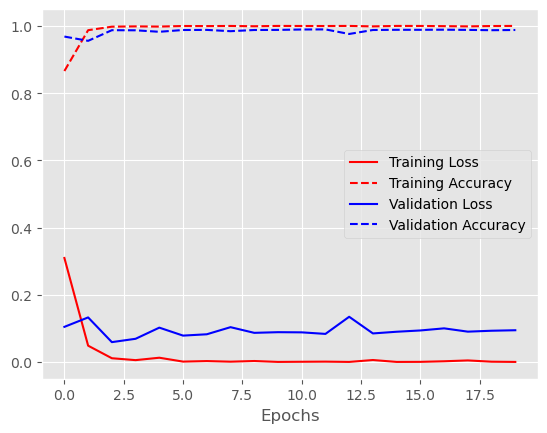

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [ ]:
binary_2gram_tf_test = text_vectorization_bi_tfidf(X_test)
binary_2gram_tf_test

<tf.Tensor: shape=(693, 20000), dtype=float32, numpy=
array([[ 409.47482  ,    6.2476535,    2.0982447, ...,    0.       ,
           0.       ,    0.       ],
       [ 341.229    ,    4.165102 ,    4.1964893, ...,    0.       ,
           0.       ,    0.       ],
       [ 797.9509   ,   20.131327 ,    4.8959045, ...,    0.       ,
           0.       ,    0.       ],
       ...,
       [1065.6844   ,   13.18949  ,    5.5953193, ...,    0.       ,
           0.       ,    0.       ],
       [ 157.49031  ,   20.825512 ,    7.693564 , ...,    0.       ,
           0.       ,    0.       ],
       [ 388.4761   ,   11.801123 ,    3.4970746, ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)>

22/22 [==============================] - 0s 4ms/step


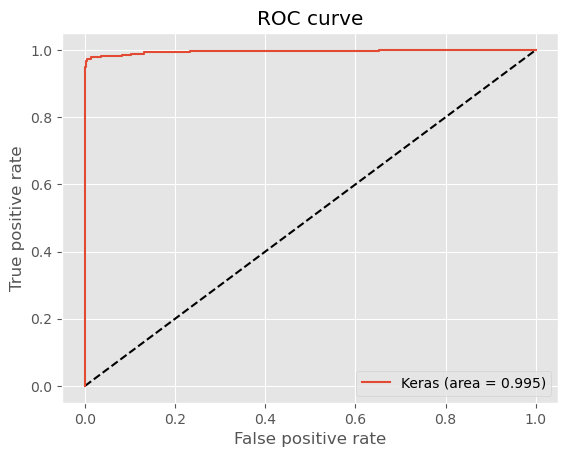

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model_bi_tfidf.predict(binary_2gram_tf_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
 model_bi_tfidf.evaluate(binary_2gram_tf_test, y_test)

22/22 [==============================] - 0s 5ms/step - loss: 0.1079 - accuracy: 0.9870


[0.10792061686515808, 0.9870129823684692]

# 4- RNN - Bidirectional LSTM 

In [21]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=1000, # maximum tokens are set to 1000 words
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    ngrams =1 # set ngram = 1 (which means we will consider the seqenuce of the documents)
)

text_vectorization.adapt(df['facts'])

In [22]:
def build_model():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=1500) # we one-hot encode those, so it becomes a length x1500 vector.
    x = layers.Bidirectional(layers.LSTM(16))(one_hot) # operating in parallel and generate 32 LSTM (embeddings) in the end
    x = layers.Dropout(0.5)(x) # prevent the overfitting
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_lstm = build_model()


In [23]:
with tf.device('/cpu:0'):
    k = 4
    num_validation_samples = len(X_train) // k
    num_epochs = 20
    batch_sizes = 250
    all_loss_histories = []
    all_val_loss_histories = []
    all_acc_histories = []
    all_val_acc_histories = []

    # For each validation fold, we will train a full set of epochs, and store the history.
    for fold in range(k):
        validation_data = X_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        validation_targets = y_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        training_data = np.concatenate([
            X_train[:num_validation_samples * fold],
            X_train[num_validation_samples * (fold + 1):]])
        training_targets = np.concatenate([
            y_train[:num_validation_samples * fold],
            y_train[num_validation_samples * (fold + 1):]])
        model_lstm = build_model()
        history = model_lstm.fit(training_data, training_targets,
                            validation_data = (validation_data,validation_targets),
                            epochs=num_epochs, batch_size=batch_sizes)
        val_loss_history = history.history['val_loss']
        val_acc_history = history.history['val_accuracy']
        loss_history = history.history['loss']
        acc_history = history.history['accuracy']
        all_val_loss_histories.append(val_loss_history)
        all_loss_histories.append(loss_history)
        all_val_acc_histories.append(val_acc_history)
        all_acc_histories.append(acc_history)

    average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
    average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
    average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
    average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/20
11/11 [==============================] - 40s 3s/step - loss: 0.6939 - accuracy: 0.5089 - val_loss: 0.6924 - val_accuracy: 0.5195
Epoch 2/20
11/11 [==============================] - 40s 4s/step - loss: 0.6921 - accuracy: 0.5270 - val_loss: 0.6916 - val_accuracy: 0.5266
Epoch 3/20
11/11 [==============================] - 34s 3s/step - loss: 0.6906 - accuracy: 0.5483 - val_loss: 0.6903 - val_accuracy: 0.5941
Epoch 4/20
11/11 [==============================] - 33s 3s/step - loss: 0.6895 - accuracy: 0.5719 - val_loss: 0.6890 - val_accuracy: 0.5562
Epoch 5/20
11/11 [==============================] - 35s 3s/step - loss: 0.6875 - accuracy: 0.5834 - val_loss: 0.6881 - val_accuracy: 0.5136
Epoch 6/20
11/11 [==============================] - 34s 3s/step - loss: 0.6809 - accuracy: 0.5952 - val_loss: 0.6775 - val_accuracy: 0.5479
Epoch 7/20
11/11 [==============================] - 35s 3s/step - loss: 0.6448 - accuracy: 0.6547 - val_loss: 0.6593 - val_accuracy: 0.5846
Epoch 8/20
11/11 [==

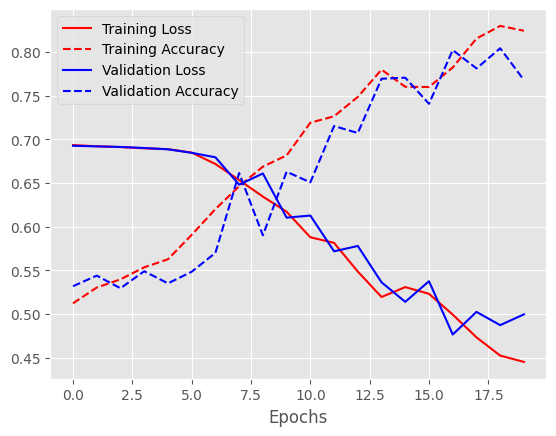

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

22/22 [==============================] - 6s 246ms/step


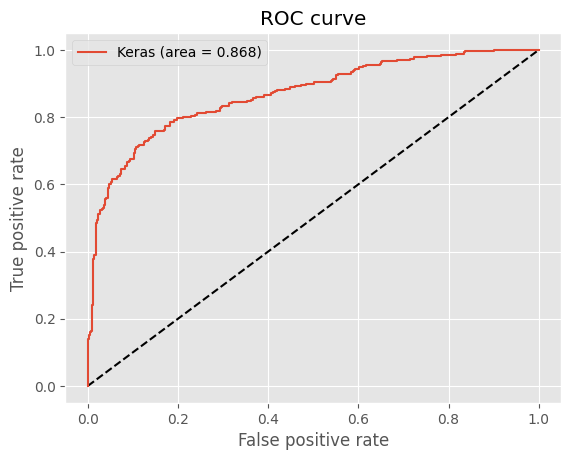

In [26]:
from sklearn.metrics import roc_curve
y_pred_keras = model_lstm.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [25]:
model_lstm.evaluate(X_test, y_test)

22/22 [==============================] - 5s 226ms/step - loss: 0.4657 - accuracy: 0.8139


[0.46565544605255127, 0.8138527870178223]

# 5- LSTM with Text Embeddings:

In [27]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=1000, # set the maximum tokens at 1000 words
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    ngrams =1 # set ngram = 1 (which means we will consider the seqenuce of the documents)
)

text_vectorization.adapt(df['facts'])

In [28]:
with tf.device('/cpu:0'):
    def build_model_text_embed():
        inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input
        processing = text_vectorization(inputs)

        #we are setting 1000 as the vocabulary size, as we will be encoding numbers 0 to 999.
        #We want the length of the word vector to be 8, hence output_dim is set to 8.
        # The length of the input sequence to embedding layer will be 500.
        # Truncates after 500 tokens, and pads up to 500 tokens for shorter facts.
        # Mask zero means it will skip 0 tokens and will not pass them on.
        x = layers.Embedding(input_dim=1000,output_dim=8,input_length=500, mask_zero=True)(processing) # Embedding layer
        x = layers.Bidirectional(layers.LSTM(12))(x) #Bidirectional LSTM layer: # operating in parallel and generate 10 LSTM (embeddings) in the end
        x = keras.layers.Dropout(0.5)(x)
        outputs = layers.Dense(1, activation="sigmoid")(x)


        model = keras.Model(inputs,outputs)
        model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
        return model

    model_lstm_text_embed = build_model_text_embed()



In [29]:
with tf.device('/cpu:0'):
    k = 4
    num_validation_samples = len(X_train) // k
    num_epochs = 20
    batch_sizes = 250
    all_loss_histories = []
    all_val_loss_histories = []
    all_acc_histories = []
    all_val_acc_histories = []

    # For each validation fold, we will train a full set of epochs, and store the history.
    for fold in range(k):
        validation_data = X_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        validation_targets = y_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        training_data = np.concatenate([
            X_train[:num_validation_samples * fold],
            X_train[num_validation_samples * (fold + 1):]])
        training_targets = np.concatenate([
            y_train[:num_validation_samples * fold],
            y_train[num_validation_samples * (fold + 1):]])
        model_lstm_text_embed = build_model_text_embed()
        history = model_lstm_text_embed.fit(training_data, training_targets,
                            validation_data = (validation_data,validation_targets),
                            epochs=num_epochs, batch_size=batch_sizes)
        val_loss_history = history.history['val_loss']
        val_acc_history = history.history['val_accuracy']
        loss_history = history.history['loss']
        acc_history = history.history['accuracy']
        all_val_loss_histories.append(val_loss_history)
        all_loss_histories.append(loss_history)
        all_val_acc_histories.append(val_acc_history)
        all_acc_histories.append(acc_history)

    average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
    average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
    average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
    average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/20
11/11 [==============================] - 15s 684ms/step - loss: 0.6934 - accuracy: 0.4986 - val_loss: 0.6926 - val_accuracy: 0.5550
Epoch 2/20
11/11 [==============================] - 6s 557ms/step - loss: 0.6920 - accuracy: 0.5459 - val_loss: 0.6919 - val_accuracy: 0.5858
Epoch 3/20
11/11 [==============================] - 5s 466ms/step - loss: 0.6912 - accuracy: 0.5715 - val_loss: 0.6909 - val_accuracy: 0.6071
Epoch 4/20
11/11 [==============================] - 5s 460ms/step - loss: 0.6896 - accuracy: 0.6015 - val_loss: 0.6894 - val_accuracy: 0.6438
Epoch 5/20
11/11 [==============================] - 6s 496ms/step - loss: 0.6873 - accuracy: 0.6512 - val_loss: 0.6873 - val_accuracy: 0.6438
Epoch 6/20
11/11 [==============================] - 5s 438ms/step - loss: 0.6841 - accuracy: 0.6740 - val_loss: 0.6835 - val_accuracy: 0.6888
Epoch 7/20
11/11 [==============================] - 6s 522ms/step - loss: 0.6778 - accuracy: 0.6878 - val_loss: 0.6756 - val_accuracy: 0.7030
Epoch

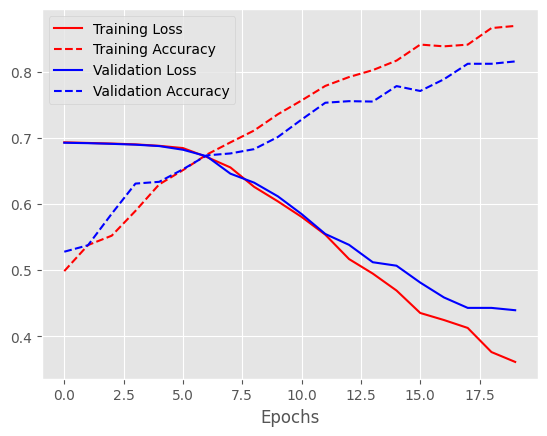

In [30]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

22/22 [==============================] - 3s 39ms/step


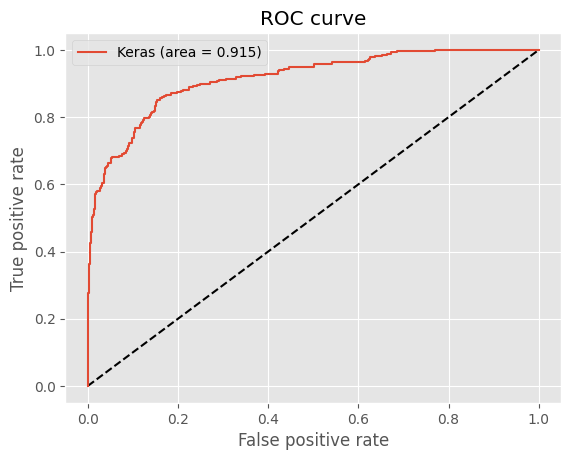

In [32]:
from sklearn.metrics import roc_curve
y_pred_keras = model_lstm_text_embed.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [31]:
model_lstm_text_embed.evaluate(X_test, y_test)

22/22 [==============================] - 1s 41ms/step - loss: 0.3811 - accuracy: 0.8398


[0.3810847997665405, 0.8398268222808838]

# Conclusion:
        Best model: Bigram with TD-IDF method performed best(AUC) among our models
        Which Means that, Output of that algorithm is much Closer to the Actual Decisions made by Supreme court